<a href="https://colab.research.google.com/github/Toomishe/Multi-Stage-Classification-of-Retinal-OCT-using-Multi-Scale-Ensemble-Deep-Architecture/blob/main/Multi_4_classes_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import *
from keras.models import *
import os
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Model
from pickle import dump

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
import random
from PIL import Image
import os

import random
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd




# MULTICLASS ON MULTI SCALE 4 CLASSES

In [ ]:
#Load model wIthout classifier/fully connected layers
base_modelM = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=3,
    classifier_activation=None  ,
)

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in base_modelM.layers:
    layer.trainable = False
# base_modelM.summary()

In [ ]:
# lOADING TRAIN DATA FOR MULTICLASS
directory = "D:/OCT Classification Project/Datasets/OCT Image/OCT2017/train"

TRX224 = []
TRY224 = []
TRX112 =[]
TRY112 = []
TRX56 = []
TRY56 = []


for folder in os.listdir(directory):
    image_lists = os.listdir(directory+'\\'+folder)
#     print(image_lists)
    for i in range(2400):
        index = random.randint(0,8500)
        image = image_lists[index]
        x = image[:6]
        y = image[:3]
        img = os.path.join(directory,folder,image)
#         print(img)
        Images = cv2.imread(img)

        # LOADING 224
        Images_224 = cv2.resize(Images, (224, 224), interpolation = cv2.INTER_AREA)

        #normalize the data set
        Images_224 = Images_224/255

        TRX224.append(Images_224)

        if x == "NORMAL":
            TRY224.append('NORMAL')
        elif y == "CNV":
            TRY224.append('CNV')
        elif y == "DME":
            TRY224.append('DME')
        elif x == "DRUSEN":
            TRY224.append('DRUSEN')



        #LOADING 112
        Images_112 = cv2.resize(Images, (112, 112), interpolation = cv2.INTER_AREA)

        #normalize the data set
        Images_112 = Images_112/255

        TRX112.append(Images_112)

        if x == "NORMAL":
            TRY112.append('NORMAL')
        elif y == "CNV":
            TRY112.append('CNV')
        elif y == "DME":
            TRY112.append('DME')
        elif x == "DRUSEN":
            TRY112.append('DRUSEN')


        #LOADING 56
        Images_56 = cv2.resize(Images, (56, 56), interpolation = cv2.INTER_AREA)

        #normalize the data set
        Images_56 = Images_56/255

        TRX56.append(Images_56)

        if x == "NORMAL":
            TRY56.append('NORMAL')
        elif y == "CNV":
            TRY56.append('CNV')
        elif y == "DME":
            TRY56.append('DME')
        elif x == "DRUSEN":
            TRY56.append('DRUSEN')



In [ ]:
# Checking the unique of loaded data
np.unique(TRY224)

array(['CNV', 'DME', 'DRUSEN', 'NORMAL'], dtype='<U6')

In [ ]:
#CONVERTING INPUTS TO ARRAY
TRX224=np.array(TRX224)
TRY224=np.array(TRY224)

TRX112=np.array(TRX112)
TRY112=np.array(TRY112)

TRX56=np.array(TRX56)
TRY56=np.array(TRY56)

In [ ]:
# Encoding Y Label
le = LabelEncoder()
MY224 = le.fit_transform(TRY224)
MY112 = le.fit_transform(TRY112)
MY56 = le.fit_transform(TRY56)

In [ ]:
#extracting features from Train set for 112 sizes
TRX112_Ft=base_modelM.predict(TRX112)

#extracting features from Train set for 56 sizes
TRX56_Ft=base_modelM.predict(TRX56)

#extracting features from Train set for 224 sizes
TRX224_Ft=base_modelM.predict(TRX224)


300/300 [==============================] - 682s 2s/step


In [ ]:
#Concatenate features of all sizes
x = np.concatenate([TRX112_Ft, TRX56_Ft, TRX224_Ft], axis=1)

In [ ]:
# Building the MLP

modelCVM = Sequential()
modelCVM.add(Flatten(input_shape=(5760,)))
modelCVM.add(Dense(64, activation='relu'))
modelCVM.add(Dropout(0.5))
modelCVM.add(BatchNormalization())
modelCVM.add(Dense(4, activation='softmax'))

In [ ]:
# Configure cross-validation

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
fold = 1
accuracies = []
for train_index, test_index in kfold.split(x, MY224):
    print(f"Training on Fold {fold}...")

    # Split the data into training and validation sets for this fold
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = MY224[train_index], MY224[test_index]

    # Compile and train the CNN model
    modelCVM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelCVM.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    _, accuracy = modelCVM.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy on Fold {fold}: {accuracy}")
    accuracies.append(accuracy)

    fold += 1

Training on Fold 1...
Epoch 1/10
60/60 [==============================] - 1s 7ms/step - loss: 0.3598 - accuracy: 0.8704 - val_loss: 0.3259 - val_accuracy: 0.8911
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3346 - accuracy: 0.8788 - val_loss: 0.3286 - val_accuracy: 0.8964
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3240 - accuracy: 0.8839 - val_loss: 0.3593 - val_accuracy: 0.8766
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.3145 - accuracy: 0.8818 - val_loss: 0.4651 - val_accuracy: 0.8234
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3156 - accuracy: 0.8835 - val_loss: 0.3323 - val_accuracy: 0.8833
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.2938 - accuracy: 0.8943 - val_loss: 0.3574 - val_accuracy: 0.8635
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3053 - accuracy: 0.8848 - val_loss: 0.3480 - val_accuracy: 0.876

In [ ]:
# Compute the average cross-validation accuracy
avg_accuracy = np.mean(accuracies)
print("Average cross-validation accuracy:", avg_accuracy)

Average cross-validation accuracy: 0.9426041722297669


In [ ]:
# Compute the average cross-validation accuracy
std_accuracy = np.std(accuracies)
print("Std cross-validation accuracy:", std_accuracy)

Std cross-validation accuracy: 0.026759690239730443


In [ ]:
# Save model to disk

import joblib
joblib.dump(modelCVM, 'MULTI_INITIAL_CV.pkl')

['MULTI_INITIAL_CV.pkl']

In [ ]:
# Evaluate the model 1
test_lossMC, test_accMC = modelCVM.evaluate(X_test, y_test)
print('MLP Test accuracy MC:', test_accMC)

60/60 [==============================] - 0s 2ms/step - loss: 0.0942 - accuracy: 0.9630
DNN Test accuracy MC: 0.9630208611488342


In [ ]:
# # Evaluate the model method 2
# Y_predMC = modelCVM.predict(X_test).argmax(axis=1)

# print("MLP Accuracy MC: ", accuracy_score(y_test, Y_predMC))

60/60 [==============================] - 0s 973us/step
DNN Accuracy MC:  0.9630208333333333


In [ ]:
# Compute the MSE
MSE_MC = metrics.mean_squared_error(y_test, Y_predMC)
print('MLP MSE:', MSE_MC)


0.08541666666666667

In [ ]:
# Plotting the confusion matrix

confusion_matrix(y_test, Y_predMC)

array([[469,   8,  11,   0],
       [  1, 469,   4,   9],
       [  5,   2, 445,  21],
       [  0,   6,   4, 466]], dtype=int64)

In [ ]:
# Plotting the classification report

from sklearn.metrics import classification_report
print(classification_report(y_test, Y_predMC))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       488
           1       0.97      0.97      0.97       483
           2       0.96      0.94      0.95       473
           3       0.94      0.98      0.96       476

    accuracy                           0.96      1920
   macro avg       0.96      0.96      0.96      1920
weighted avg       0.96      0.96      0.96      1920



In [ ]:
# Calculate specificity and sensitivity USING MLP

def calculate_specificity(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    tn = sum(cm.diagonal()) - cm[class_label, class_label]
    fp = sum(cm[:, class_label]) - cm[class_label, class_label]
    specificity = tn / (tn + fp)
    return specificity

def calculate_overall_specificity(y_true, y_pred, num_classes):
    overall_specificity = 0.0
    for class_label in range(num_classes):
        specificity = calculate_specificity(y_true, y_pred, class_label)
        overall_specificity += specificity
        print("Specificity for class", class_label, ":", specificity)
    overall_specificity /= num_classes
    print("Overall specificity:", overall_specificity)
    model_listMC=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes']
    resultMC__ = pd.DataFrame ({"Model": model_listMC, "specificity":specificity, "overall":overall_specificity})

def calculate_sensitivity(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[class_label, class_label]
    fn = sum(cm[class_label, :]) - tp
    sensitivity = tp / (tp + fn)
    return sensitivity

def calculate_overall_sensitivity(y_true, y_pred, num_classes):
    overall_sensitivity = 0.0
    for class_label in range(num_classes):
        sensitivity = calculate_sensitivity(y_true, y_pred, class_label)
        overall_sensitivity += sensitivity
        print("Sensitivity for class", class_label, ":", sensitivity)
    overall_sensitivity /= num_classes
    print("Overall sensitivity:", overall_sensitivity)
    model_listMC=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes']
    resultMC__ = pd.DataFrame ({"Model": model_listMC, "sensitivity":sensitivity, "overall":overall_sensitivity})

calculate_overall_specificity(y_test, Y_predMC, 4)
calculate_overall_sensitivity(y_test, Y_predMC, 4)



Specificity for class 0 : 0.9956709956709957
Specificity for class 1 : 0.9885386819484241
Specificity for class 2 : 0.9866479269149684
Specificity for class 3 : 0.9787685774946921
Overall specificity: 0.9874065455072701
Sensitivity for class 0 : 0.9610655737704918
Sensitivity for class 1 : 0.9710144927536232
Sensitivity for class 2 : 0.9408033826638478
Sensitivity for class 3 : 0.9789915966386554
Overall sensitivity: 0.9629687614566547


In [ ]:
# machine learning model_pipeline for different classifiers

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn. tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear', max_iter=10000))
model_pipeline.append (SVC(probability=True, max_iter=10000))
model_pipeline.append(DecisionTreeClassifier ())
model_pipeline.append(RandomForestClassifier ())
model_pipeline.append(GaussianNB ( ))

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score


model_listMC=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes']

acc_listMC = []
cm_listMC = []
MSEMC = []
scores_avgMC = []
scores_stdMC = []
cv_mean =[]

for model in model_pipeline:
  model.fit (X_train, y_train)
  MulClass_pred = model.predict (X_test)
  acc_listMC.append(metrics.accuracy_score(y_test, MulClass_pred))
  cm_listMC.append(confusion_matrix(y_test, MulClass_pred))
  MSEMC.append(mean_squared_error(y_test, MulClass_pred))
  scores_avgMC.append((cross_val_score(model, x, MY224, cv=5, scoring='f1_macro')).mean())
  scores_stdMC.append((cross_val_score(model, x, MY224, cv=5, scoring='f1_macro')).std())
  cv_mean.append((cross_val_score(model, x, MY224, cv=5, scoring='f1_macro')))


resultMC = pd.DataFrame ({"Model": model_listMC, "Accuracy":acc_listMC, "MSE":MSEMC, "scores_avg":scores_avgMC, "scores_std":scores_stdMC})
resultMC.append({'Model': 'DNN', "Accuracy":test_accMC, "MSE":MSE_MC},  ignore_index=True)

C:\Users\Akinniyi\AppData\Local\Temp\ipykernel_3828\1663683249.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultMC.append({'Model': 'DNN', "Accuracy":test_accMC, "MSE":MSE_MC},  ignore_index=True)


,Model,Accuracy,MSE,scores_avg,scores_std
0,Logistic Regression,0.860938,0.343229,0.859450,0.004272
1,SVM,0.857292,0.321354,0.865261,0.004931
2,Decision Tree,0.664062,0.894271,0.652293,0.020031
3,Random Forest,0.824479,0.420833,0.810983,0.009814
4,Naive Bayes,0.636979,0.904167,0.638179,0.011513
5,DNN,0.963021,0.085417,NaN,NaN


In [ ]:
# Calculate specificity and sensitivity USING ALL CLASSIFIERS

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear', max_iter=10000))
model_pipeline.append (SVC(probability=True, max_iter=10000))
model_pipeline.append(DecisionTreeClassifier ())
model_pipeline.append(RandomForestClassifier ())
model_pipeline.append(GaussianNB ( ))
model_listMC=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes']

# specificityMC = []
# sensitivityMC = []

for model in model_pipeline:
  model.fit (X_train, y_train)
  MulClass_pred = model.predict (X_test)
  calculate_overall_specificity(y_test, MulClass_pred, 4)
  calculate_overall_sensitivity(y_test, MulClass_pred, 4)
# specificityMC.append(calculate_overall_specificity(Y_test, MulClass_pred, 4))
# sensitivityMC.append(calculate_overall_sensitivity(Y_test, MulClass_pred, 4))


# resultMC__ = pd.DataFrame ({"Model": model_listMC, "specificity":specificityMC, "sensitivity":sensitivityMC})

Specificity for class 0 : 0.9670846394984326
Specificity for class 1 : 0.9451737451737452
Specificity for class 2 : 0.9357459379615952
Specificity for class 3 : 0.9485011529592621
Overall specificity: 0.9491263688982587
Sensitivity for class 0 : 0.8586065573770492
Sensitivity for class 1 : 0.8881987577639752
Sensitivity for class 2 : 0.8160676532769556
Sensitivity for class 3 : 0.8802521008403361
Overall sensitivity: 0.860781267314579
Specificity for class 0 : 0.9777247414478918
Specificity for class 1 : 0.9586905689789555
Specificity for class 2 : 0.9320672023374726
Specificity for class 3 : 0.9232540291634689
Overall specificity: 0.9479341354819473
Sensitivity for class 0 : 0.8545081967213115
Sensitivity for class 1 : 0.8612836438923396
Sensitivity for class 2 : 0.7822410147991543
Sensitivity for class 3 : 0.930672268907563
Overall sensitivity: 0.857176281080092
Specificity for class 0 : 0.8657276995305164
Specificity for class 1 : 0.8480786416443253
Specificity for class 2 : 0.83728

In [ ]:
# Ensemble of all Confusion Matrix

cm_listMC
cm_listMC.append(confusion_matrix(y_test, Y_predMC))
cm_listMC

[array([[419,  29,  38,   2],
        [ 10, 429,  18,  26],
        [ 27,  21, 386,  39],
        [  5,  21,  31, 419]], dtype=int64),
 array([[417,  23,  46,   2],
        [  9, 416,  24,  34],
        [ 19,  20, 370,  64],
        [  0,  10,  23, 443]], dtype=int64),
 array([[342,  53,  69,  24],
        [ 54, 314,  52,  63],
        [ 70,  65, 277,  61],
        [ 14,  54,  66, 342]], dtype=int64),
 array([[415,  38,  33,   2],
        [ 13, 393,  28,  49],
        [ 42,  22, 341,  68],
        [  4,  17,  21, 434]], dtype=int64),
 array([[309,  53, 113,  13],
        [ 40, 246, 126,  71],
        [ 62,  28, 296,  87],
        [ 13,  31,  60, 372]], dtype=int64)]

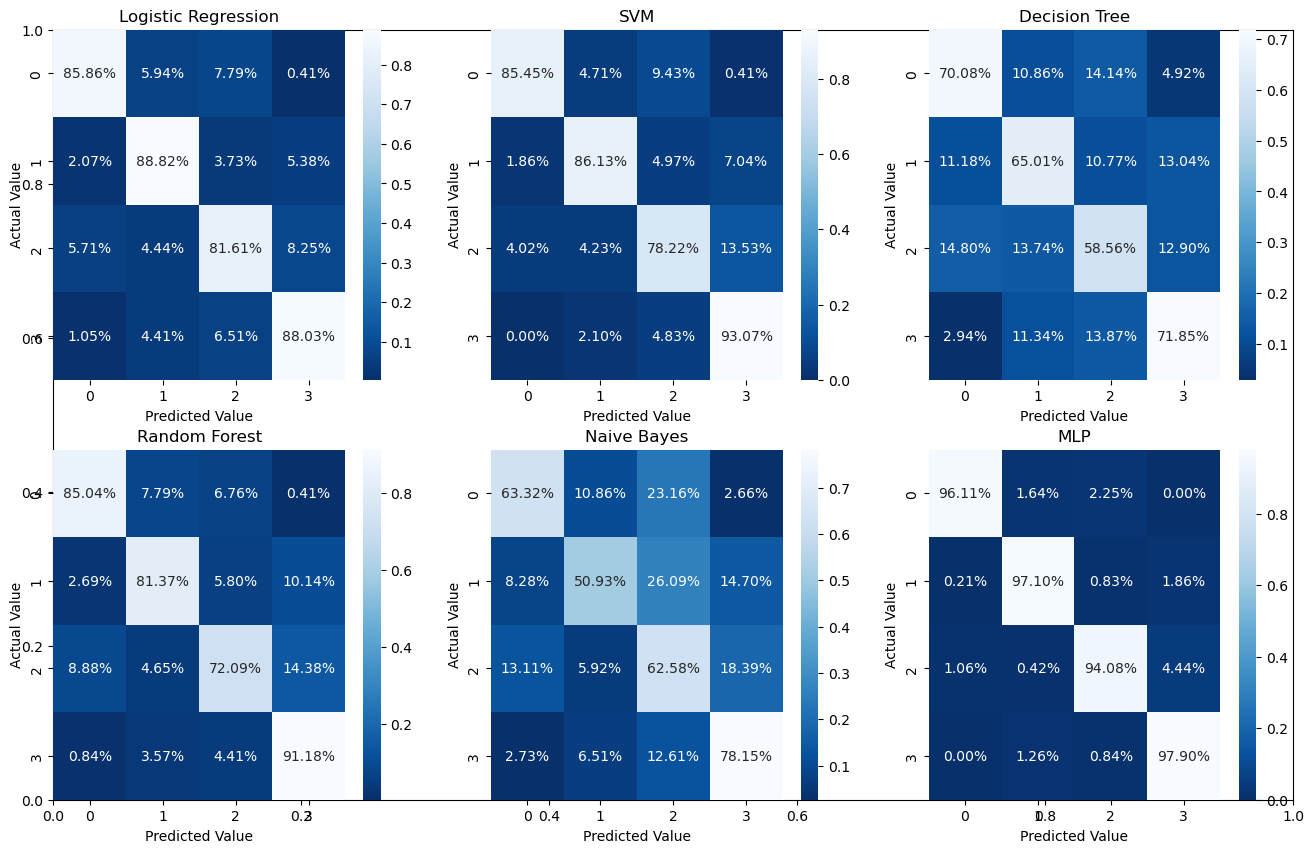

In [ ]:
# Plot confusion matrix
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(figsize=(16, 10))
model_list_all=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes', 'MLP']
for i in range (len(cm_listMC)):
  cmMC=cm_listMC[i]
  modelMC = model_list_all[i]
  sub=fig.add_subplot(2,3,i+1).set_title(modelMC)
  cm_sumMC = np.sum(cmMC, axis=1, keepdims=True)
#   cm_sumMC = np.sum(cmMC, axis=1, keepdims=True)
  cm_plotMC=sns.heatmap(cmMC/cm_sumMC.astype(float), annot=True,
            fmt='.2%', cmap='Blues_r')
  cm_plotMC.set_xlabel("Predicted Value")
  cm_plotMC.set_ylabel("Actual Value")

fig.savefig('confusion_matrix_multiclass_CV.png')

# ROC CURVE MULTI CLASS

In [ ]:
#PLOTTING ROC CURVE FOR MULTICLASS

In [ ]:
# Identify unique label
label = np.unique(TRY224)
label

array(['CNV', 'DME', 'DRUSEN', 'NORMAL'], dtype='<U6')

In [ ]:
# Identify number of classes

classes = len(np.unique(TRY224))

In [ ]:
# One hot encode the labels

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
Y_onehot_test = label_binarizer.transform(y_test)
Y_onehot_test.shape  # (n_samples, n_classes)

(1920, 4)

In [ ]:
# check for encoding
label_binarizer.transform([0])

class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

array([[1, 0, 0, 0]])

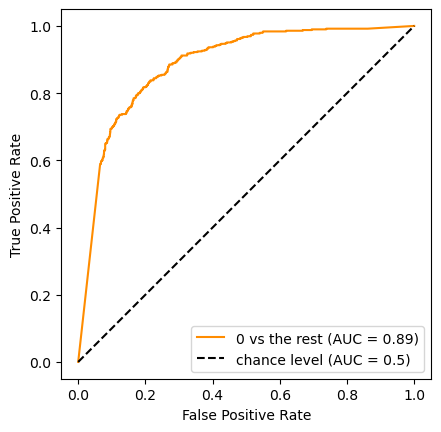

In [ ]:
# Plot OVR ROC FOR CLASSIFIER RESULTS

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

class_of_interest = 0

class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

Y_score = model.fit(X_train, y_train).predict_proba(X_test)

RocCurveDisplay.from_predictions(
    Y_onehot_test[:, class_id],
    Y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("One-vs-Rest ROC curves:\n DRUSEN vs (DME, CNV)")
plt.legend()
plt.show()

fig.savefig('ROC_OVR_multiclass_CV.png')

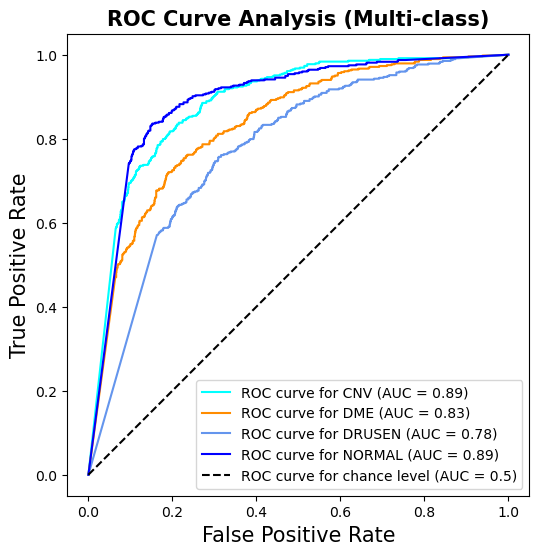

In [ ]:
# Plot ALL CLASSES ROC FOR CLASSIFIER RESULTS

from itertools import cycle

fig, ax = plt.subplots(figsize=(8, 6))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue"])
for class_id, color in zip(range(classes), colors):
    RocCurveDisplay.from_predictions(
        Y_onehot_test[:, class_id],
        Y_score[:, class_id],
        name=f"ROC curve for {label[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve Analysis (Multi-class)", fontweight='bold', fontsize=15)
plt.legend()
plt.show()
fig.savefig('ROC_Curve_multiclass_CV.png')

60/60 [==============================] - 0s 1ms/step


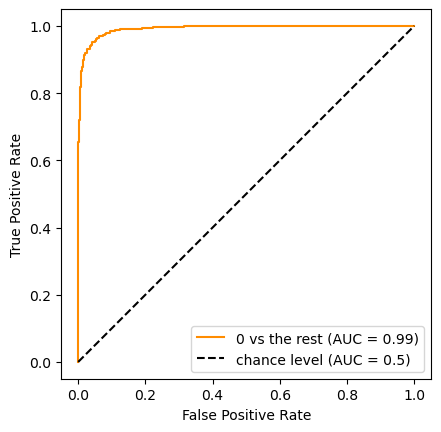

In [ ]:
# Plot OVR ROC FOR MLP RESULT


from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

class_of_interest = 0

class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

Y_score_ = predicted_probabilities = modelCVM.predict(X_test)
Y_score_

# # Y_score = modelCVM.fit(X_train, y_train).predict_proba(X_test)

RocCurveDisplay.from_predictions(
    Y_onehot_test[:, class_id],
    Y_score_[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("One-vs-Rest ROC curves:\n DRUSEN vs (DME, CNV)")
plt.legend()
plt.show()

fig.savefig('ROC_OVR_multiclass_MLP_CV.png')

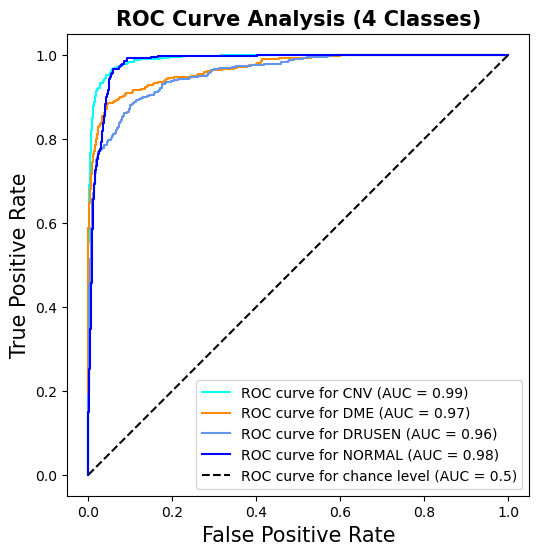

In [ ]:
# Plot ALL CLASSES ROC FOR MLP RESULT

from itertools import cycle

fig, ax = plt.subplots(figsize=(8, 6))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue"])
for class_id, color in zip(range(classes), colors):
    RocCurveDisplay.from_predictions(
        Y_onehot_test[:, class_id],
        Y_score_[:, class_id],
        name=f"ROC curve for {label[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve Analysis (4 Classes)", fontweight='bold', fontsize=15)
plt.legend()
plt.show()
fig.savefig('ROC_Curve_4Classes_MLP_CV.png')